Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Visualization for images during transform augmentation

This tutorial shows how to visualize image with `matplotlib` based on MONAI `matshow3d` API, with `TensorBoard` based on MONAI `plot_2d_or_3d_image` API, with `itkwidgets` for interactive visualization. Also shows how to blend 2 images with the same shape then use `matplotlib` to plot `image`, `label`, `blend result` accordingly.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/transform_visualization.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, matplotlib]"

# install itkwidgets for the tutorial
!pip install -q itkwidgets

# install tensorboard-plugin-3d for the tutorial
!pip install -q tensorboard-plugin-3d

%matplotlib inline

## Setup imports

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
from monai.utils import first, set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.data import DataLoader, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
import tempfile
import shutil
import os
import glob
import matplotlib.pyplot as plt
from itkwidgets import view

print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/Data


## Download dataset

Downloads and extracts the dataset.  
Here we use the `images` and `labels` of spleen 3D segmentation task, comes from http://medicaldecathlon.com/.

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [ ]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Setup MONAI transforms

In [ ]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

## Get the transform results in DataLoader

In [ ]:
check_ds = Dataset(data=data_dicts, transform=transform)
check_loader = DataLoader(check_ds, batch_size=1)
data = first(check_loader)
print(f"image shape: {data['image'].shape}, label shape: {data['label'].shape}")

image shape: (1, 1, 281, 328, 136), label shape: (1, 1, 281, 328, 136)


## Visualize the image with MONAI `matshow3d` API

`matshow3d` can plot the frames of 3D image along selected `dimension` with specified size.

Here we set `figsize=(100, 100), every_n=10, frame_dim=-1` to use the last dimension as frames and subsample the frames so that only every 10th frame is displayed.

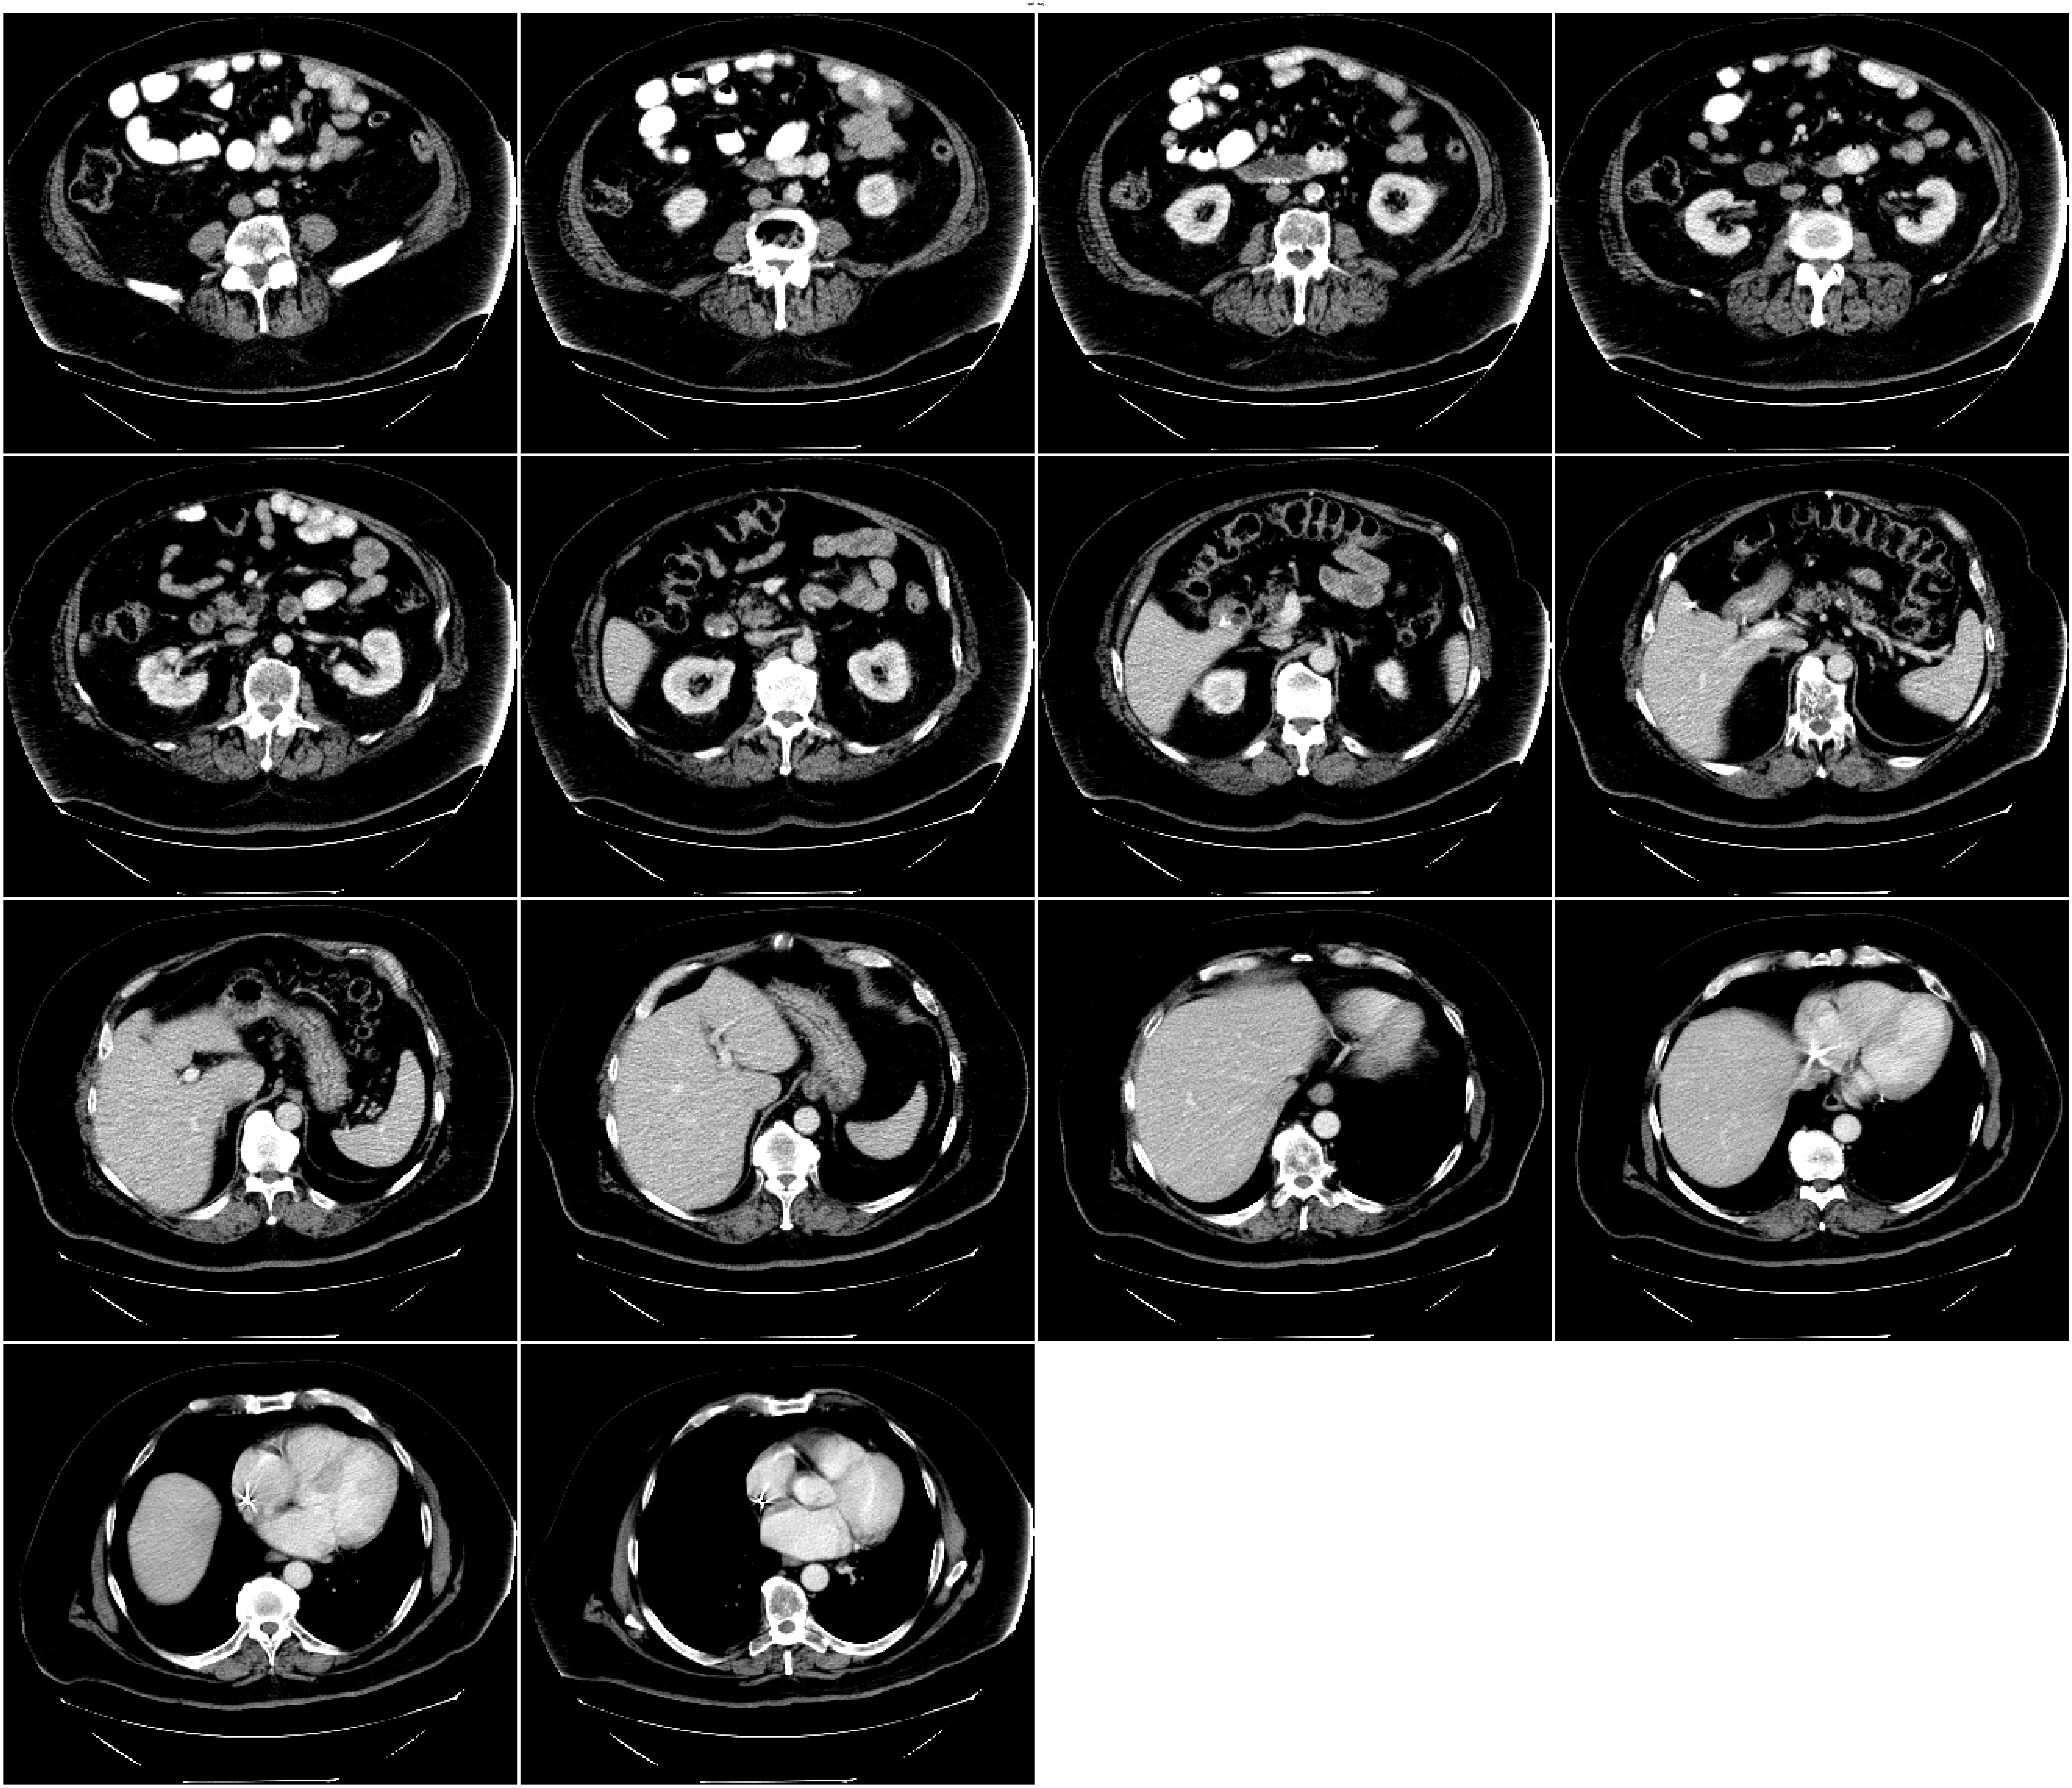

(<Figure size 7200x7200 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

In [ ]:
matshow3d(
    volume=data["image"],
    fig=None,
    title="input image",
    figsize=(100, 100),
    every_n=10,
    frame_dim=-1,
    show=True,
    cmap="gray",
)

## Visualize the 3D image in TensorBoard as GIF images

MONAI provides `plot_2d_or_3d_image` and the related ignite handler to plot 3D image as GIF image in TensorBoard. Users can set the `max_channels` to plot.

And for 3D RGB color image, it also can be plotted as video in `TensorBoardX`.

In [ ]:
tb_dir = os.path.join(root_dir, "tensorboard")
plot_2d_or_3d_image(data=data["image"], step=0, writer=SummaryWriter(log_dir=tb_dir), frame_dim=-1)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=$tb_dir

Expected output for reference (screenshot of the GIF image):
![image-2.png](attachment:image-2.png)

## Leverage `itkwidgets` to interactively visualize `image` and `label`

`itkwidgets` expects image and label with no batch or channel dim, and we set `gradient_opacity=0.4` so that no slider adjustments need to be made. For more details, please check: https://github.com/InsightSoftwareConsortium/itkwidgets.

In [ ]:
view(image=data["image"][0, 0, :, :, :] * 255, label_image=data["label"][0, 0, :, :, :] * 255, gradient_opacity=0.4)

Expected output for reference (screenshot of the widget):
![image.png](attachment:image.png)

## Blend the image and label to check the segmentation region

MONAI provides API `blend_images` to blend the `image` and `label` to a RGB color image.

It expects `channel-first` data shape, and users can specify colormap in the matplotlib, default to `hsv`. For more details, please refer to https://matplotlib.org/2.0.2/users/colormaps.html.

In [ ]:
ret = blend_images(image=data["image"][0], label=data["label"][0], alpha=0.5, cmap="hsv", rescale_arrays=False)
print(ret.shape)

torch.Size([3, 282, 329, 136])


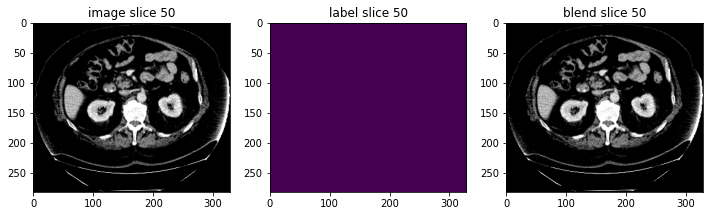

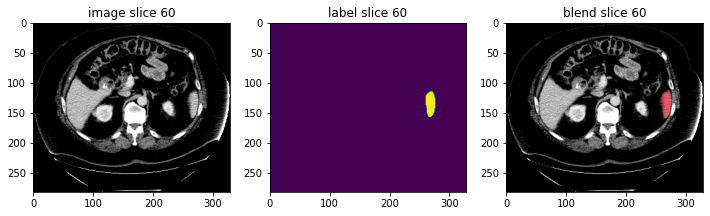

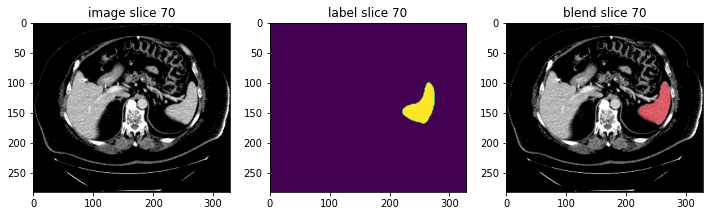

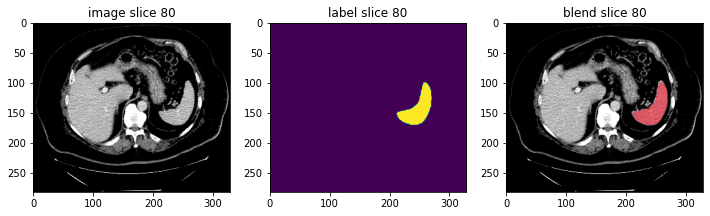

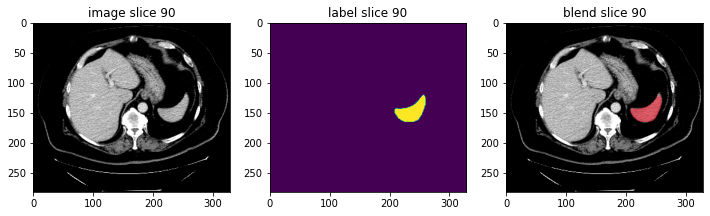

In [ ]:
for i in range(5, 10):
    # plot the slice 50 - 100 of image, label and blend result
    slice_index = 10 * i
    plt.figure("blend image and label", (12, 4))
    plt.subplot(1, 3, 1)
    plt.title(f"image slice {slice_index}")
    plt.imshow(data["image"][0, 0, :, :, slice_index], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"label slice {slice_index}")
    plt.imshow(data["label"][0, 0, :, :, slice_index])
    plt.subplot(1, 3, 3)
    plt.title(f"blend slice {slice_index}")
    # switch the channel dim to the last dim
    plt.imshow(torch.moveaxis(ret[:, :, :, slice_index], 0, -1))
    plt.show()

## Visualize the image with TensorBoardPlugin3D
MONAI provides `plot_2d_or_3d_image` and the related ignite handler to plot the 3D image in TensorBoard.

Selecting the TensorBoard 3D tab will load the first volume and its associated label (if there is one), along with tools for adjusting the image color map, sample distance, color range, label image blend, and more.

In [ ]:
# Create directories to use as TensorBoard log directories
output_dir = os.path.join(root_dir, "image_with_label")

# Visualize the input image and label
sw = SummaryWriter(log_dir=output_dir)
plot_2d_or_3d_image(data=data["image"], step=0, writer=sw, frame_dim=-1, tag="image")
plot_2d_or_3d_image(data=data["label"], step=0, writer=sw, frame_dim=-1, tag="label")

In [ ]:
# Note: plot_2d_or_3d_image may take some time to write the required event file.
# If the "Tensorboard 3D" tab is not immediately available or an image and/or
# label is not yet displayed, wait a minute and then re-run this cell.

%load_ext tensorboard
%tensorboard --logdir=$output_dir

Expected output for reference (screenshot of the 3D image):
![image.png](attachment:image.png)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)